In [1]:
import random
from pathlib import Path

import torch
import torchvision.models as models
from torchvision import transforms
from torchinfo import summary

from load_data_functions import create_cv_datasets, create_dataloaders
from engine import load_enet_best, get_loss_optimizer, create_writer, train, pretty_json, plot_loss_curves, pred_and_plot_n_images, calculate_cv_performance

In [2]:
# get current hyperparameter setup
batch_size = 64
loss_fn_str = "MSE"
learning_rate = 0.001
optimizer_str = "Adam"
num_epochs = 10
train_percentage = 1.0
dropout = 0

In [3]:
# other variables relevant for training
split_path = Path("data/train_test_split")
fold_list = [split_path / f"fold_{i}" for i in range(1, 6)]
img_size = 224
model_name = "pretrained_enet"

In [4]:
# setup device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
# create a writer to track training results
writer = create_writer(f"model_selection_cv", model_name)

[INFO] Created SummaryWriter, saving to: runs\model_selection_cv\pretrained_enet\2024-05-26_17-49-20...


In [6]:
# track hyperparameters and other important information
info = {
        "model_name": model_name,
        "batch_size": batch_size,
        "loss_fn_str": loss_fn_str,
        "learning_rate": learning_rate,
        "augmentation": False,
        "split_path": str(split_path),
        "fold_list": [str(fold) for fold in fold_list],
        "img_size": img_size,
        "num_epochs": num_epochs,
        "optimizer_str": optimizer_str,
        "percentage": train_percentage
    }

writer.add_text("Miscellaneous", pretty_json(info))

In [7]:
# define the transforms (standard transforms are performed, as these are not specified in Toisoul et al., 2021)
data_transforms = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [8]:
# perform cross_validation
datasets = create_cv_datasets(fold_list, data_transforms, select_one=False, train_percentage=train_percentage)
cv_results = {}
for fold in datasets.keys():
    train_data = datasets[fold]["train"]
    validation_data = datasets[fold]["validation"]
    print("\n----------------------------------------------------------------------------------------")
    print(f"Size of the training set: {len(train_data)}")
    print(f"Size of the validation set: {len(validation_data)}")
    train_loader, val_loader = create_dataloaders(train_data, validation_data, device, batch_size)

    # initialize model and optimizer
    model = load_enet_best(device, dropout=dropout)
    loss_fn, optimizer = get_loss_optimizer(loss_fn_str, optimizer_str, model, learning_rate)
    
    print(f"Training results for {fold}:")
    cv_results[fold] = train(num_epochs=num_epochs,
                             model=model,
                             train_loader=train_loader,
                             val_loader=val_loader,
                             loss_fn=loss_fn,
                             optimizer=optimizer,
                             device=device,
                             writer=writer,
                             early_stopping=False)


----------------------------------------------------------------------------------------
Size of the training set: 19803
Size of the validation set: 4915
[INFO] Created a new pretrained EfficientNet-B0 model.
Training results for fold_1:


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0453 | train_ccc: 0.6428 | train_pcc: 0.6852 | val_loss: 0.0540 | val_ccc: 0.2669 | val_pcc: 0.3901
Epoch: 2 | train_loss: 0.0302 | train_ccc: 0.7642 | train_pcc: 0.7962 | val_loss: 0.0587 | val_ccc: 0.2538 | val_pcc: 0.3687
Epoch: 3 | train_loss: 0.0265 | train_ccc: 0.7945 | train_pcc: 0.8212 | val_loss: 0.0606 | val_ccc: 0.2033 | val_pcc: 0.2929
Epoch: 4 | train_loss: 0.0245 | train_ccc: 0.8111 | train_pcc: 0.8373 | val_loss: 0.0561 | val_ccc: 0.2408 | val_pcc: 0.3325
Epoch: 5 | train_loss: 0.0238 | train_ccc: 0.8186 | train_pcc: 0.8426 | val_loss: 0.0566 | val_ccc: 0.2505 | val_pcc: 0.3344
Epoch: 6 | train_loss: 0.0237 | train_ccc: 0.8230 | train_pcc: 0.8458 | val_loss: 0.0605 | val_ccc: 0.2309 | val_pcc: 0.3155
Epoch: 7 | train_loss: 0.0219 | train_ccc: 0.8348 | train_pcc: 0.8561 | val_loss: 0.0813 | val_ccc: 0.1240 | val_pcc: 0.1731
Epoch: 8 | train_loss: 0.0239 | train_ccc: 0.8272 | train_pcc: 0.8471 | val_loss: 0.0742 | val_ccc: 0.2382 | val_pcc: 0.3284


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0461 | train_ccc: 0.6072 | train_pcc: 0.6634 | val_loss: 0.0399 | val_ccc: 0.3185 | val_pcc: 0.4355
Epoch: 2 | train_loss: 0.0320 | train_ccc: 0.7365 | train_pcc: 0.7762 | val_loss: 0.0367 | val_ccc: 0.3285 | val_pcc: 0.4399
Epoch: 3 | train_loss: 0.0289 | train_ccc: 0.7710 | train_pcc: 0.8014 | val_loss: 0.0602 | val_ccc: 0.2382 | val_pcc: 0.3330
Epoch: 4 | train_loss: 0.0261 | train_ccc: 0.7921 | train_pcc: 0.8211 | val_loss: 0.0395 | val_ccc: 0.3248 | val_pcc: 0.4289
Epoch: 5 | train_loss: 0.0262 | train_ccc: 0.7984 | train_pcc: 0.8253 | val_loss: 0.0507 | val_ccc: 0.2808 | val_pcc: 0.3881
Epoch: 6 | train_loss: 0.0242 | train_ccc: 0.8111 | train_pcc: 0.8363 | val_loss: 0.0449 | val_ccc: 0.3349 | val_pcc: 0.4439
Epoch: 7 | train_loss: 0.0233 | train_ccc: 0.8181 | train_pcc: 0.8425 | val_loss: 0.0778 | val_ccc: 0.2121 | val_pcc: 0.2961
Epoch: 8 | train_loss: 0.0231 | train_ccc: 0.8238 | train_pcc: 0.8466 | val_loss: 0.0499 | val_ccc: 0.2826 | val_pcc: 0.3782


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0436 | train_ccc: 0.6706 | train_pcc: 0.7116 | val_loss: 0.0517 | val_ccc: 0.2562 | val_pcc: 0.3773
Epoch: 2 | train_loss: 0.0290 | train_ccc: 0.7775 | train_pcc: 0.8101 | val_loss: 0.0499 | val_ccc: 0.2436 | val_pcc: 0.3783
Epoch: 3 | train_loss: 0.0268 | train_ccc: 0.8000 | train_pcc: 0.8254 | val_loss: 0.0555 | val_ccc: 0.2161 | val_pcc: 0.3305
Epoch: 4 | train_loss: 0.0266 | train_ccc: 0.8095 | train_pcc: 0.8323 | val_loss: 0.0637 | val_ccc: 0.1925 | val_pcc: 0.3005
Epoch: 5 | train_loss: 0.0241 | train_ccc: 0.8250 | train_pcc: 0.8465 | val_loss: 0.0536 | val_ccc: 0.2200 | val_pcc: 0.3493
Epoch: 6 | train_loss: 0.0238 | train_ccc: 0.8306 | train_pcc: 0.8505 | val_loss: 0.0561 | val_ccc: 0.2293 | val_pcc: 0.3517
Epoch: 7 | train_loss: 0.0231 | train_ccc: 0.8363 | train_pcc: 0.8566 | val_loss: 0.0549 | val_ccc: 0.2345 | val_pcc: 0.3599
Epoch: 8 | train_loss: 0.0220 | train_ccc: 0.8422 | train_pcc: 0.8617 | val_loss: 0.0594 | val_ccc: 0.1943 | val_pcc: 0.3026


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0446 | train_ccc: 0.6455 | train_pcc: 0.6915 | val_loss: 0.0471 | val_ccc: 0.2394 | val_pcc: 0.3721
Epoch: 2 | train_loss: 0.0313 | train_ccc: 0.7594 | train_pcc: 0.7941 | val_loss: 0.0474 | val_ccc: 0.2275 | val_pcc: 0.3753
Epoch: 3 | train_loss: 0.0284 | train_ccc: 0.7860 | train_pcc: 0.8144 | val_loss: 0.0507 | val_ccc: 0.2165 | val_pcc: 0.3501
Epoch: 4 | train_loss: 0.0260 | train_ccc: 0.8073 | train_pcc: 0.8331 | val_loss: 0.0504 | val_ccc: 0.2218 | val_pcc: 0.3606
Epoch: 5 | train_loss: 0.0247 | train_ccc: 0.8186 | train_pcc: 0.8417 | val_loss: 0.0564 | val_ccc: 0.2109 | val_pcc: 0.3337
Epoch: 6 | train_loss: 0.0242 | train_ccc: 0.8243 | train_pcc: 0.8465 | val_loss: 0.0639 | val_ccc: 0.1854 | val_pcc: 0.2933
Epoch: 7 | train_loss: 0.0221 | train_ccc: 0.8383 | train_pcc: 0.8599 | val_loss: 0.0534 | val_ccc: 0.2167 | val_pcc: 0.3387
Epoch: 8 | train_loss: 0.0230 | train_ccc: 0.8355 | train_pcc: 0.8556 | val_loss: 0.0547 | val_ccc: 0.2271 | val_pcc: 0.3471


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.0463 | train_ccc: 0.6332 | train_pcc: 0.6785 | val_loss: 0.0456 | val_ccc: 0.2603 | val_pcc: 0.3892
Epoch: 2 | train_loss: 0.0311 | train_ccc: 0.7537 | train_pcc: 0.7876 | val_loss: 0.0508 | val_ccc: 0.2316 | val_pcc: 0.3620
Epoch: 3 | train_loss: 0.0275 | train_ccc: 0.7878 | train_pcc: 0.8152 | val_loss: 0.0476 | val_ccc: 0.2546 | val_pcc: 0.3832
Epoch: 4 | train_loss: 0.0255 | train_ccc: 0.8036 | train_pcc: 0.8297 | val_loss: 0.0687 | val_ccc: 0.1944 | val_pcc: 0.2788
Epoch: 5 | train_loss: 0.0253 | train_ccc: 0.8100 | train_pcc: 0.8349 | val_loss: 0.0578 | val_ccc: 0.2538 | val_pcc: 0.3847
Epoch: 6 | train_loss: 0.0251 | train_ccc: 0.8154 | train_pcc: 0.8379 | val_loss: 0.0541 | val_ccc: 0.2147 | val_pcc: 0.3228
Epoch: 7 | train_loss: 0.0229 | train_ccc: 0.8282 | train_pcc: 0.8502 | val_loss: 0.0487 | val_ccc: 0.2542 | val_pcc: 0.3728
Epoch: 8 | train_loss: 0.0222 | train_ccc: 0.8348 | train_pcc: 0.8565 | val_loss: 0.0548 | val_ccc: 0.2206 | val_pcc: 0.3222


In [9]:
# calculate average performance across folds 
cv_performance = calculate_cv_performance(cv_results, num_epochs, writer)

{'mean_ccc': [0.26825157881482653, 0.2570205003999163, 0.2257471836773938, 0.23485102786429848, 0.24317927640914805, 0.23904010708585602, 0.2083011137693632, 0.2325575708483001, 0.21642077568277066, 0.2458412462481967], 'mean_pcc': [0.39284572074265134, 0.38485371337390184, 0.3379052709639163, 0.34026033845620784, 0.3580390779146511, 0.3454454466293823, 0.3081220166590077, 0.3357210944733925, 0.3043831369091487, 0.3503530000049799]}


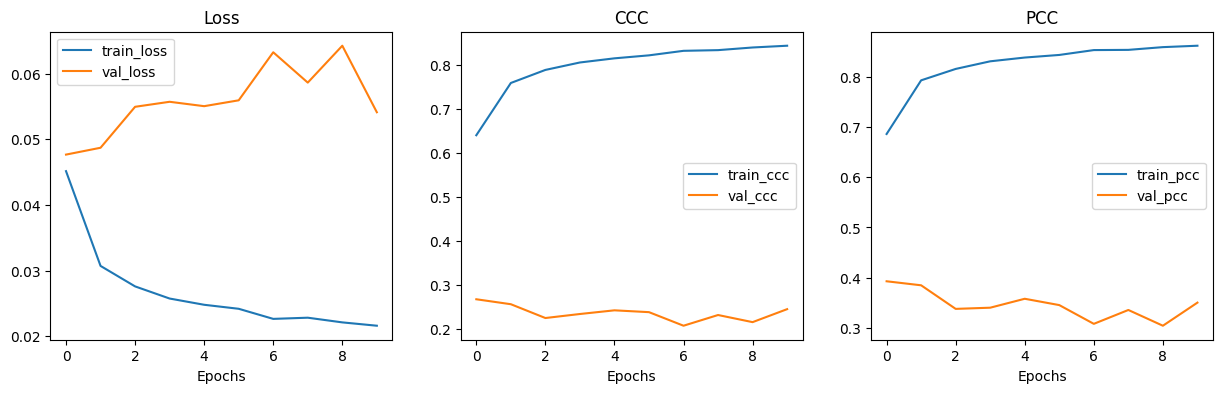

In [10]:
# plot loss curves
plot_loss_curves(cv_performance)